In [1]:
pip install pygraphviz


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge pygraphviz


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/christinastodt/anaconda3/envs/AnomalyTest

  added / updated specs:
    - pygraphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libsqlite-3.45.1           |       h091b4b1_0         805 KB  conda-forge
    pygraphviz-1.11            |   py39h58ae6e2_2         128 KB  conda-forge
    python-3.9.18              |hd7ebdb9_1_cpython        11.3 MB  conda-forge
    python_abi-3.9             |           4_cp39           6 KB  conda-forge
    tk-8.6.13                  |       h5083fa2_1         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        15.2 MB

The following NEW packages will be INSTALLED:

  libsqlite          conda-forge/osx-arm64::libsqlite-3.45.1-h091

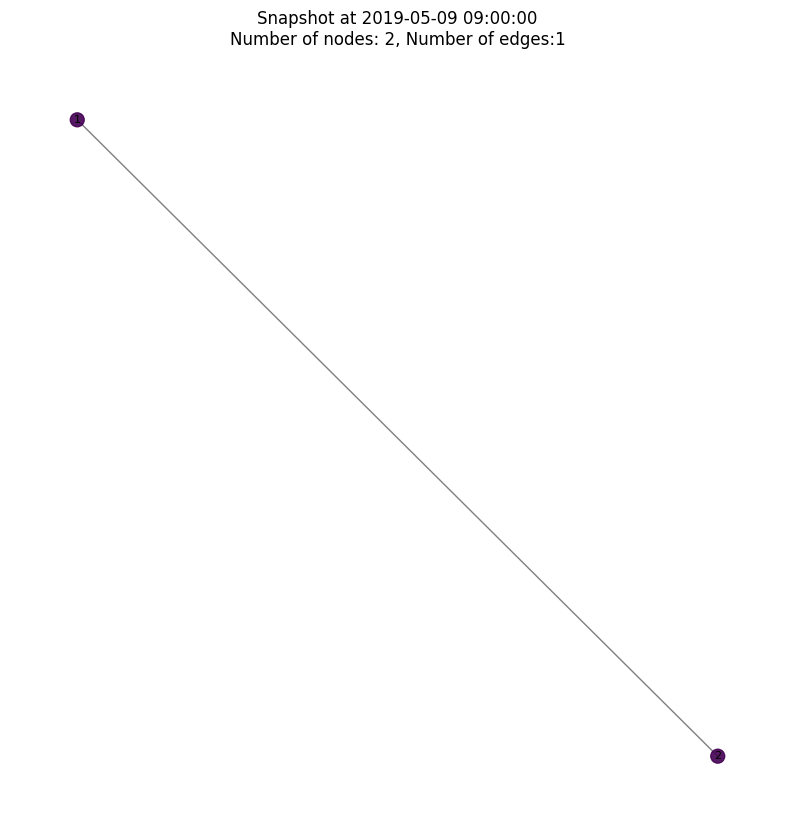

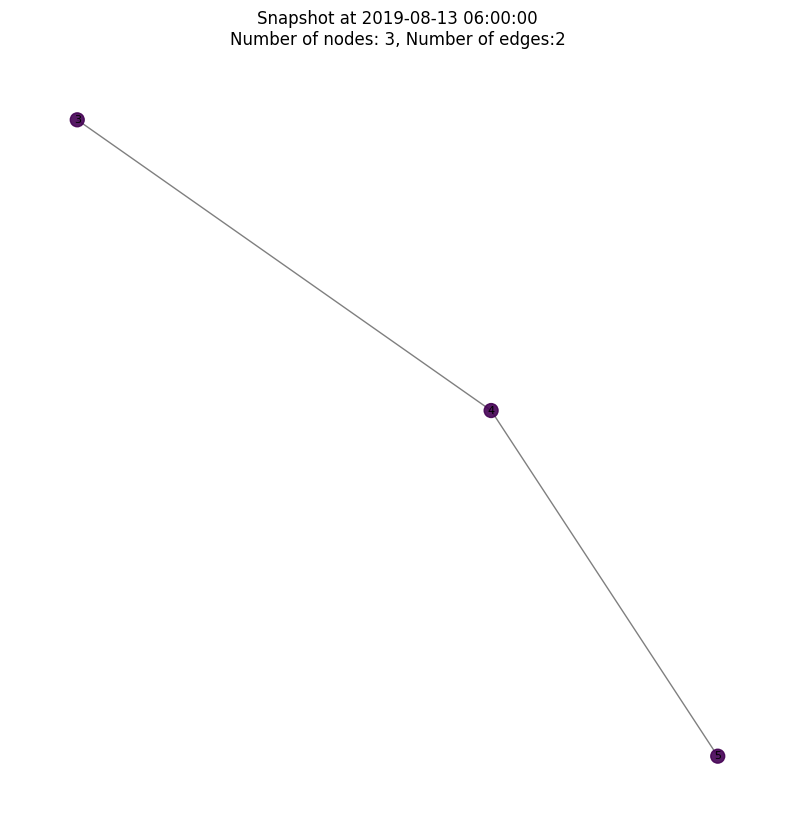

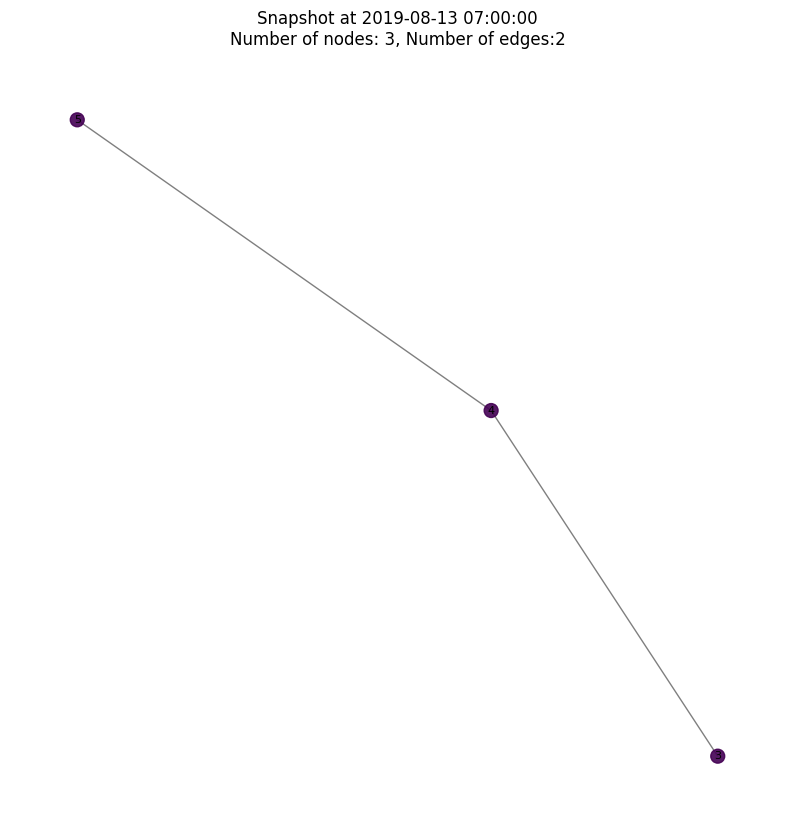

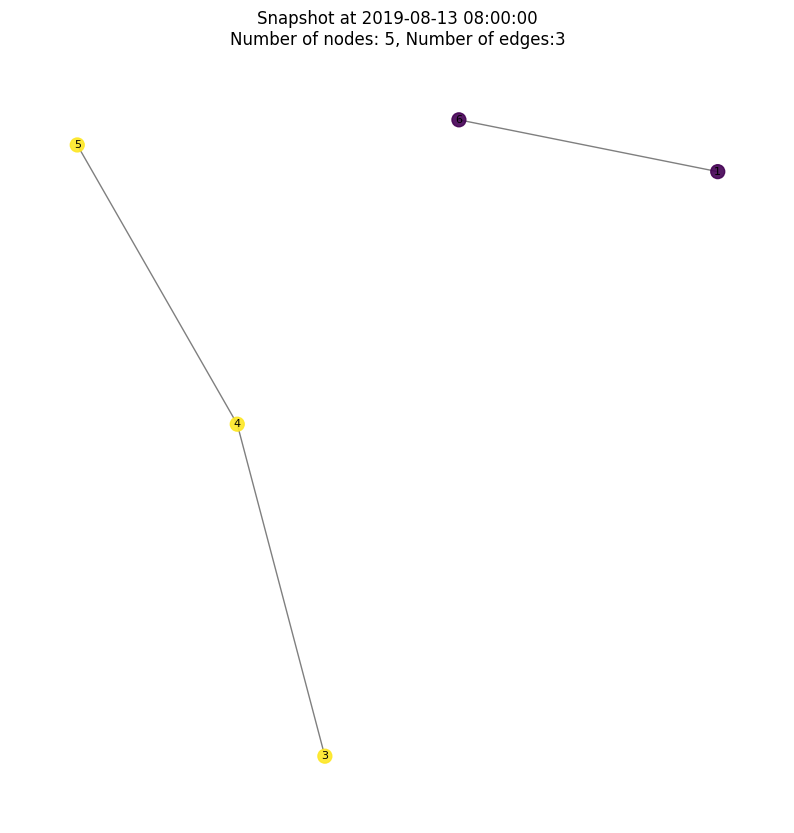

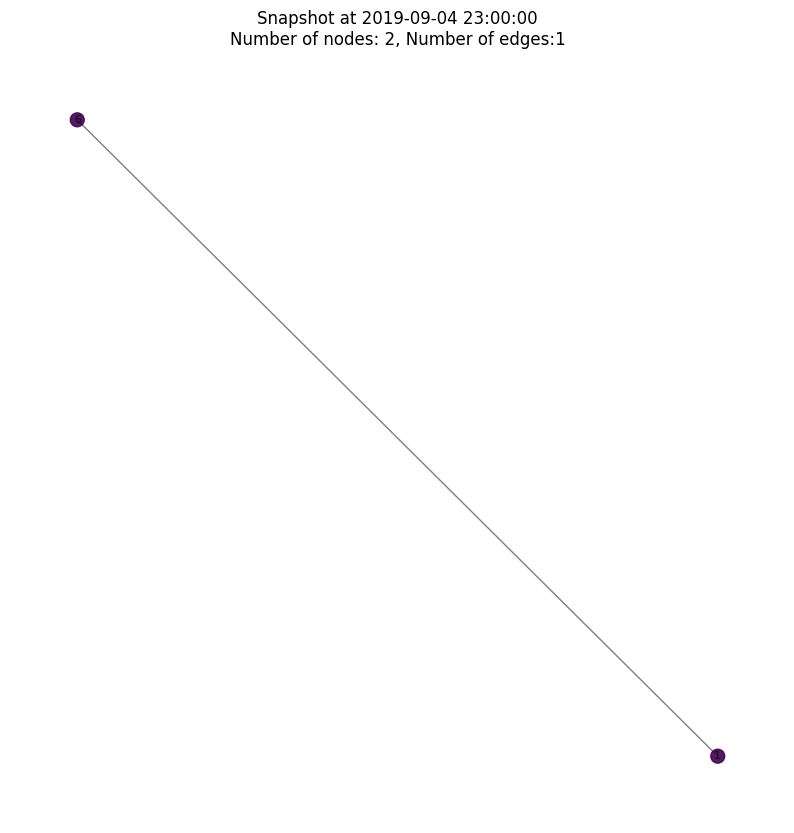

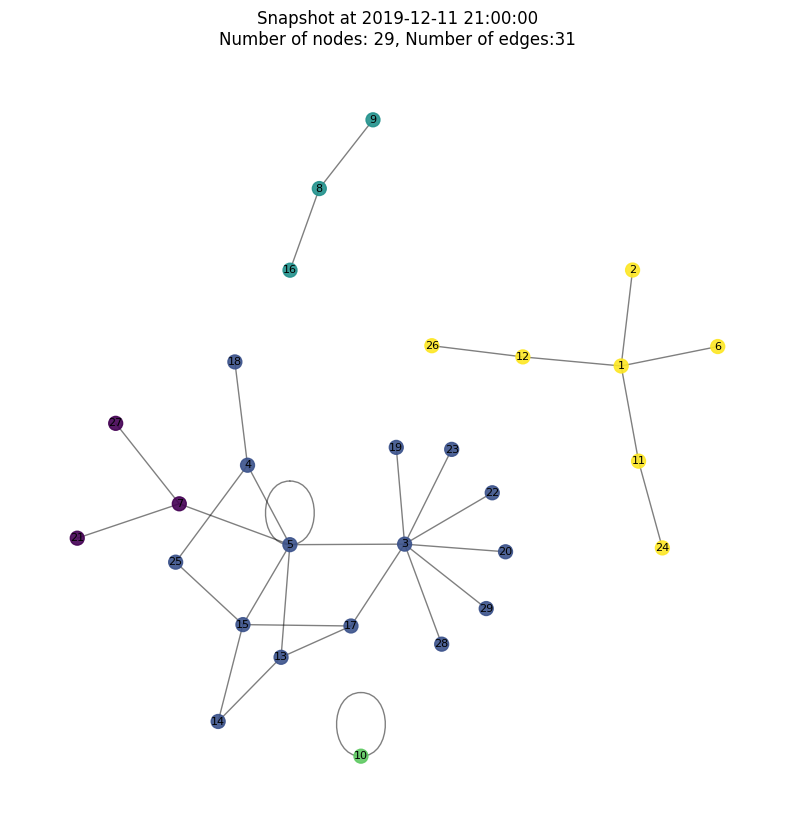

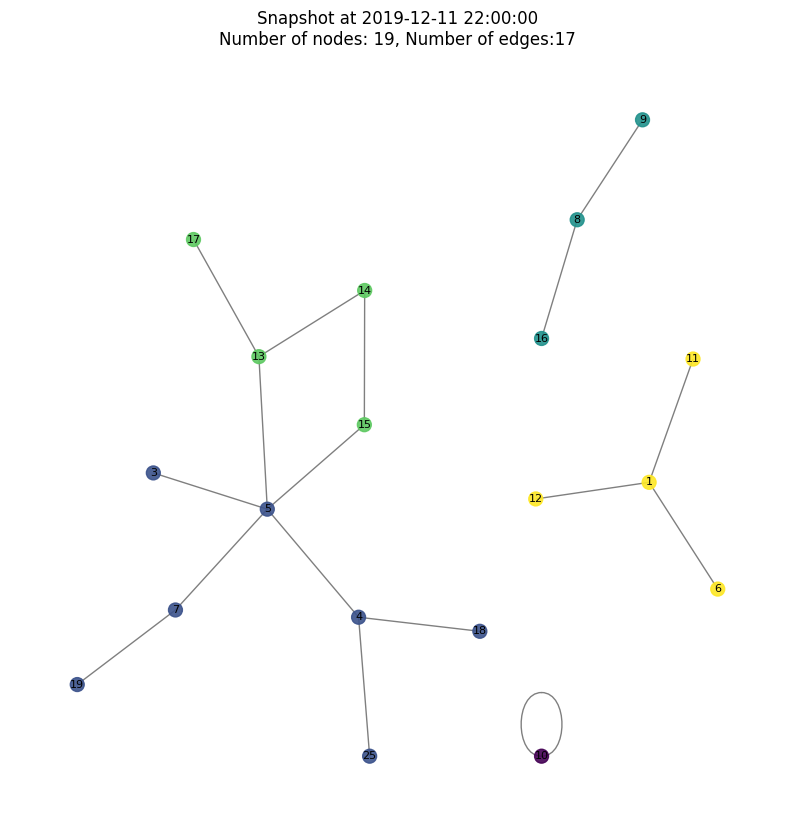

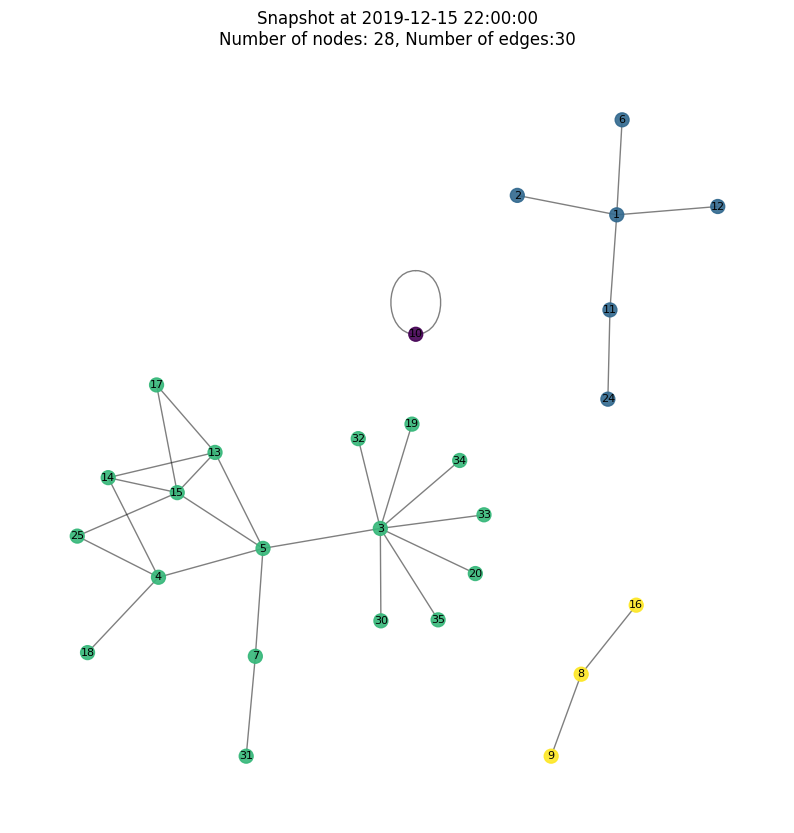

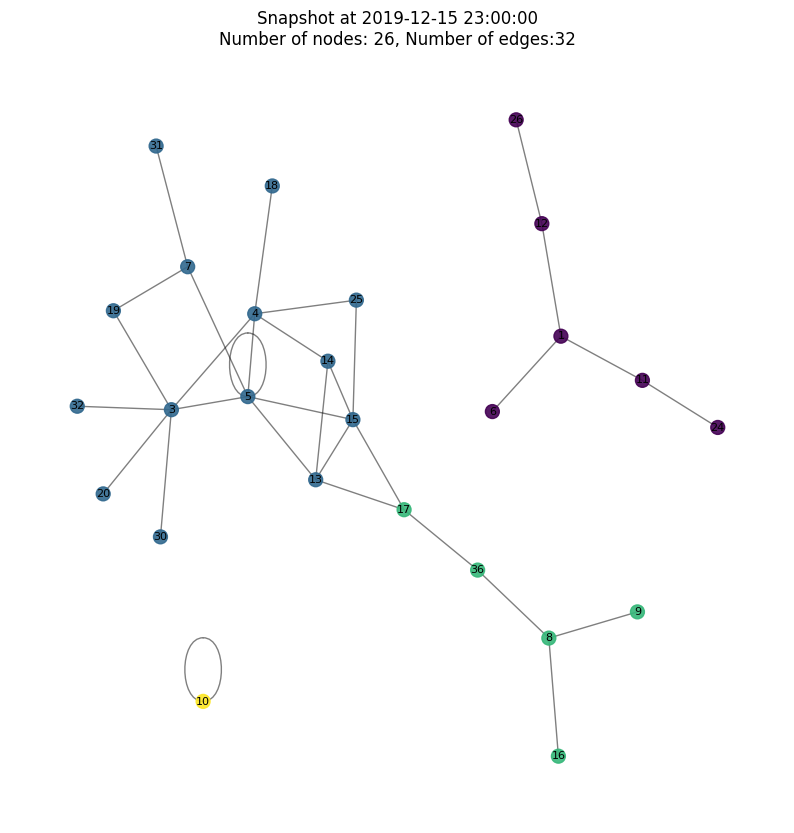

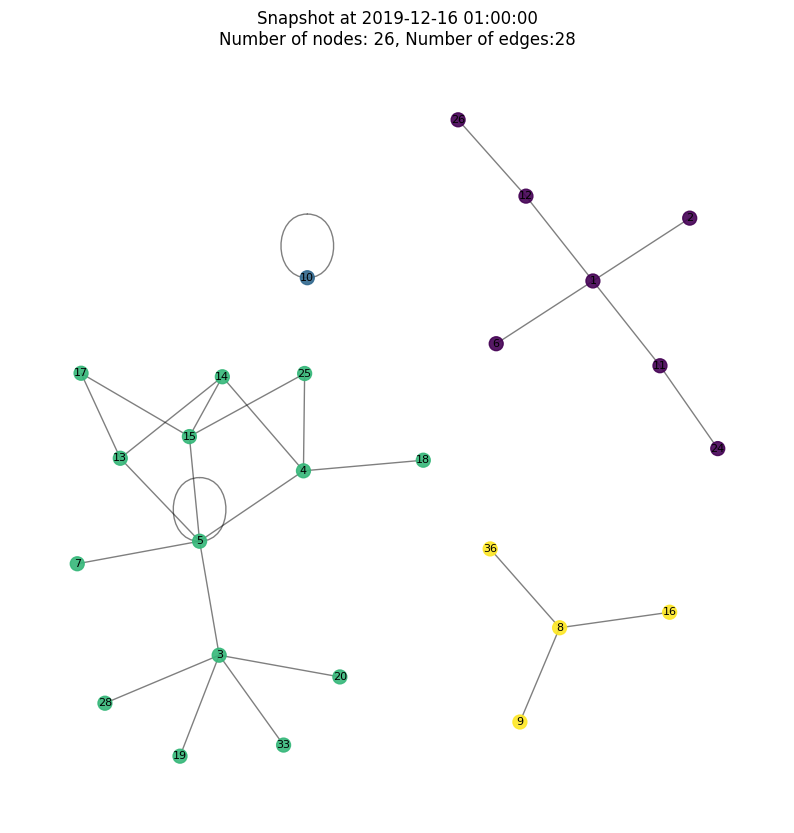

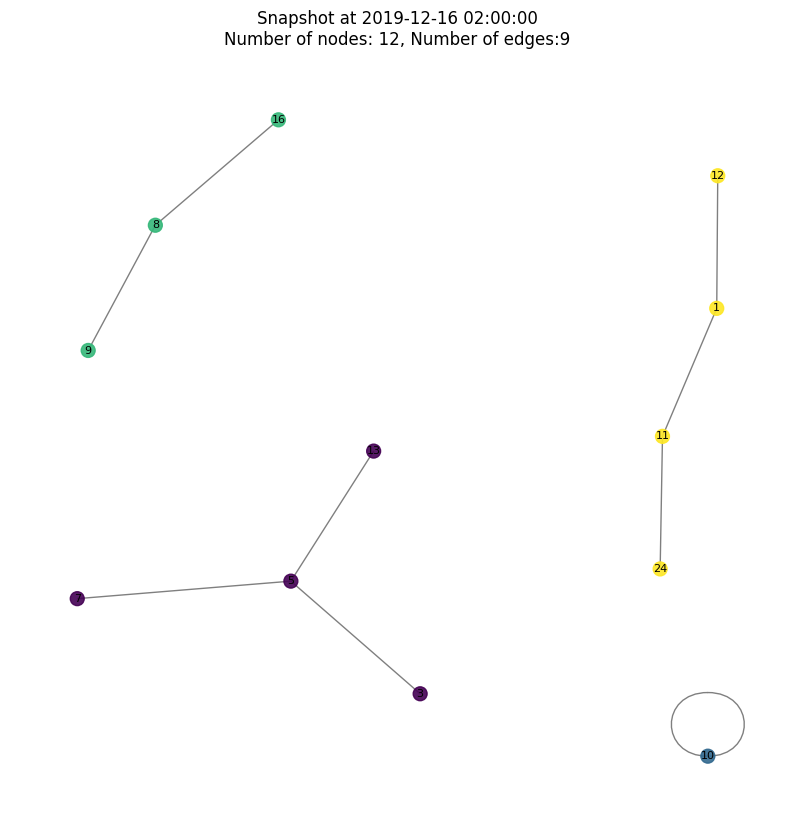

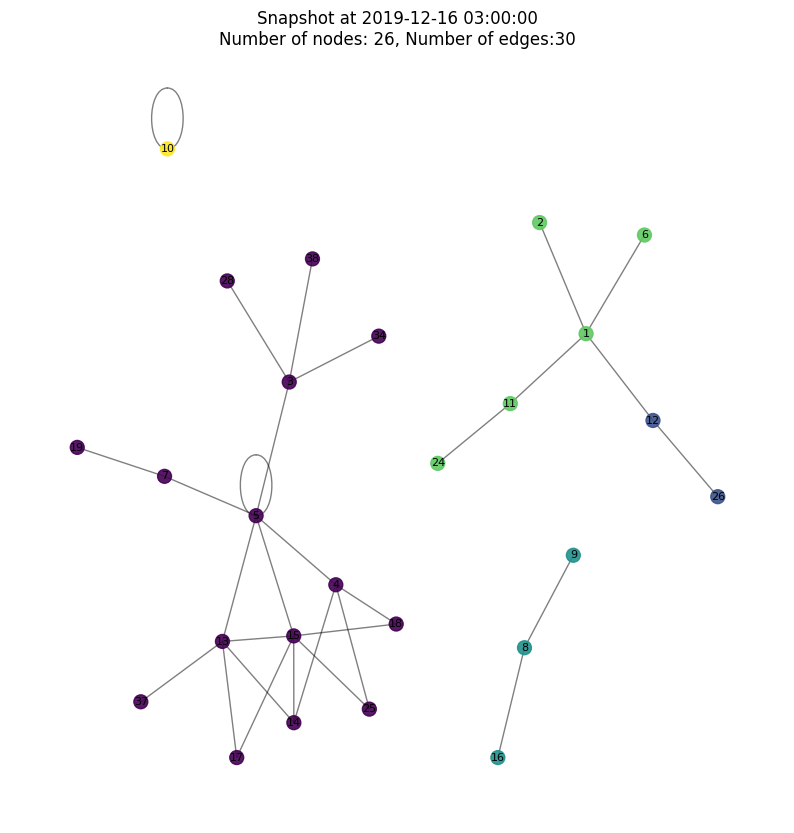

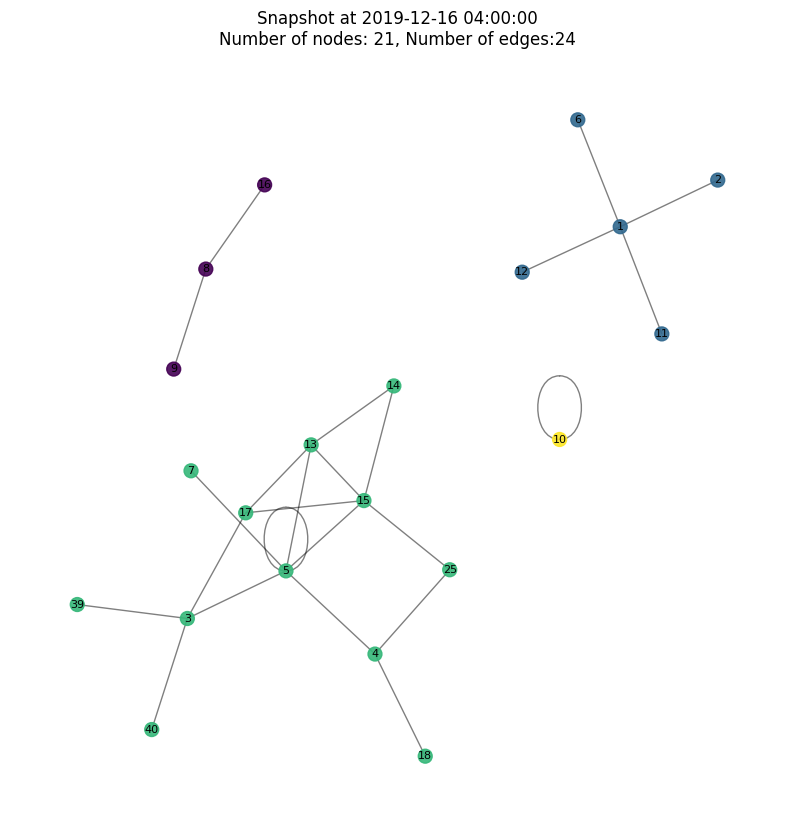

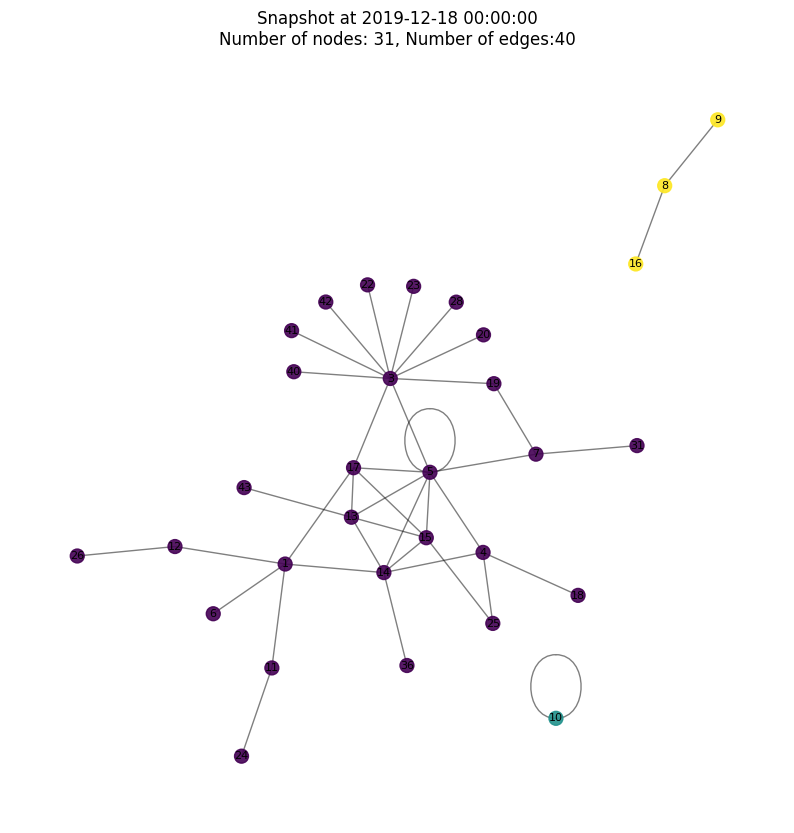

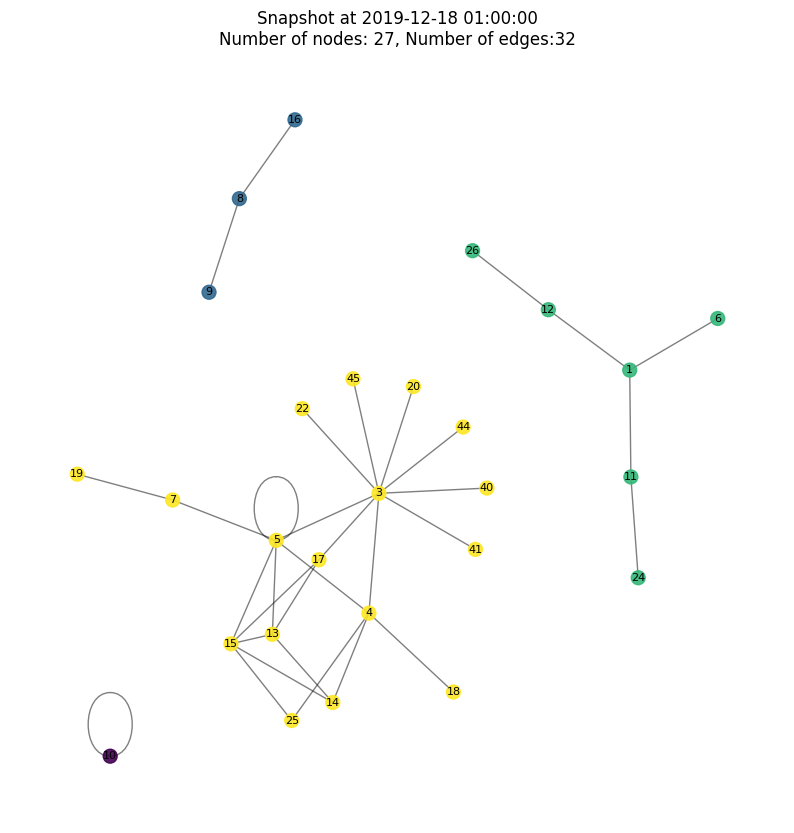

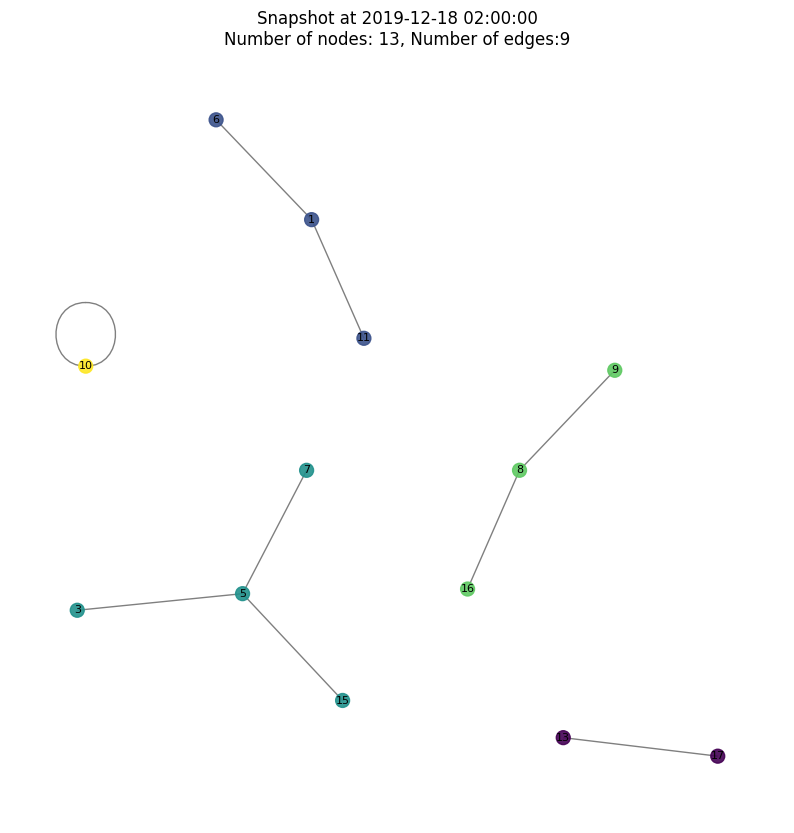

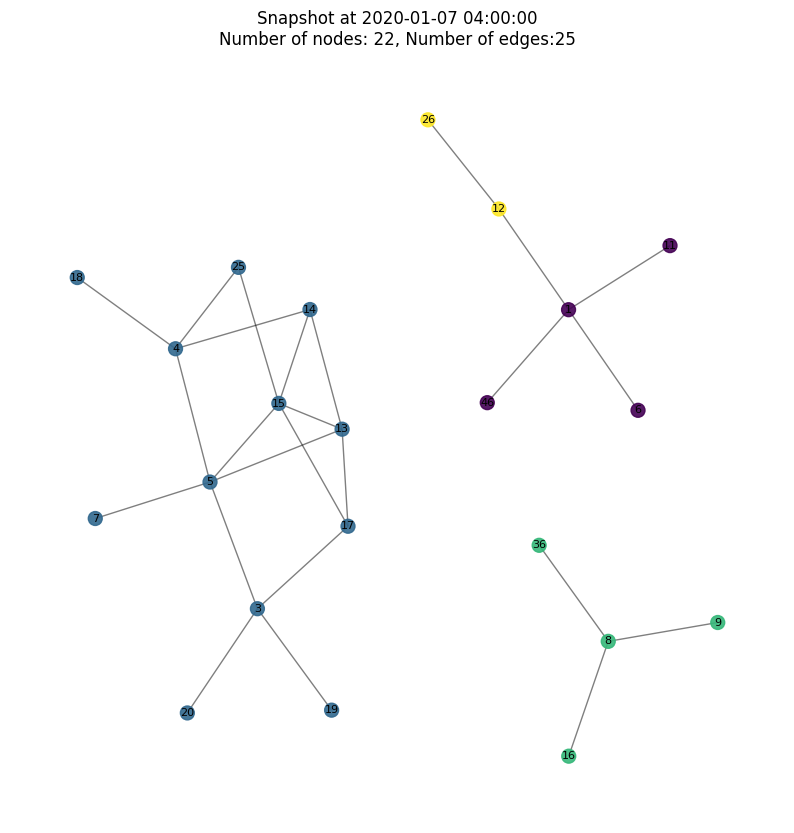

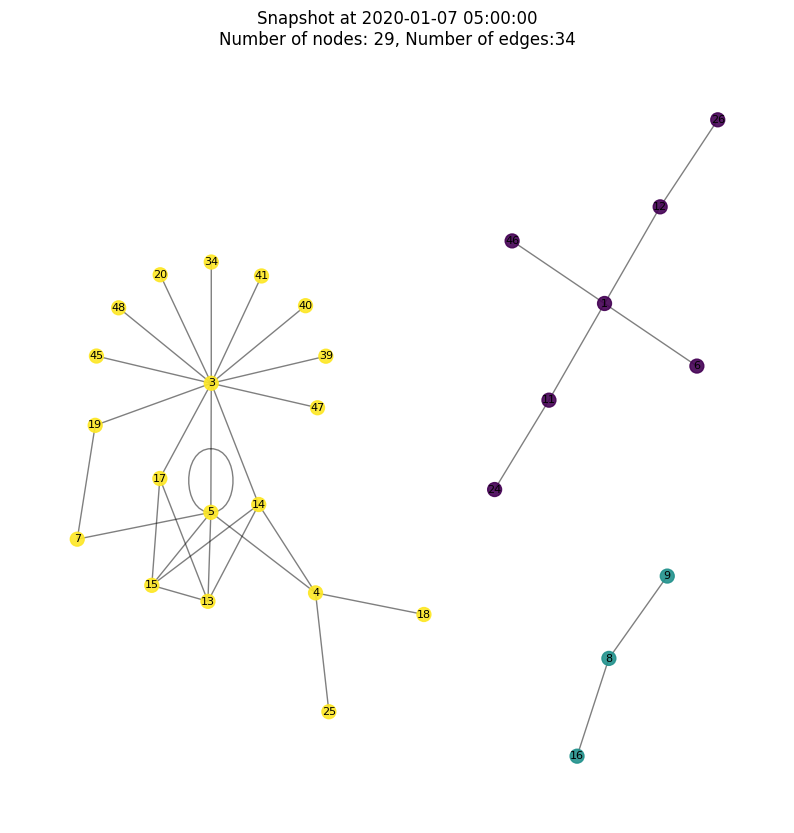

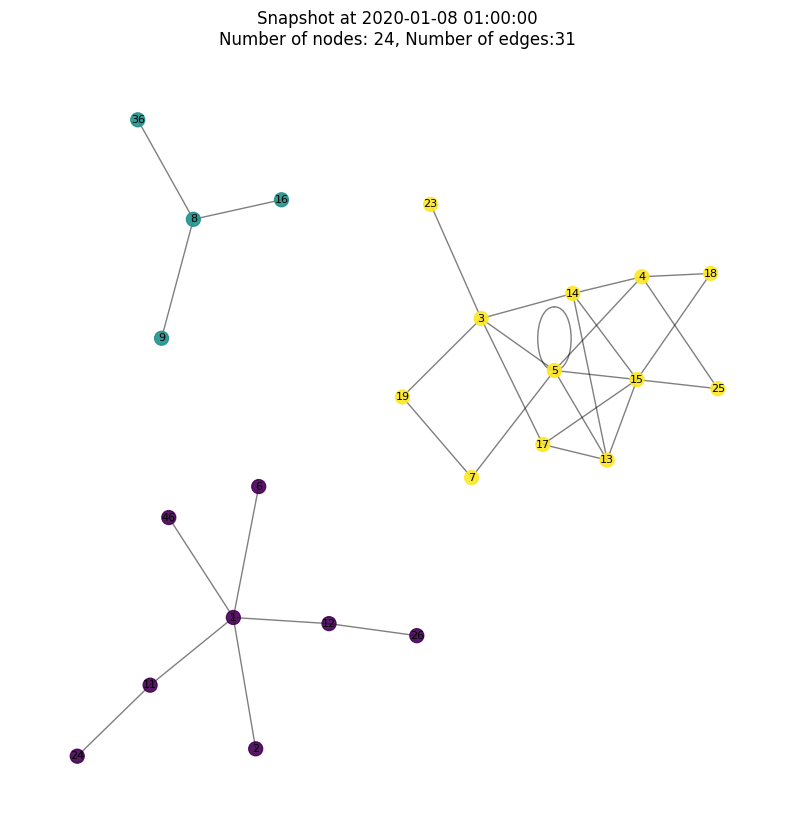

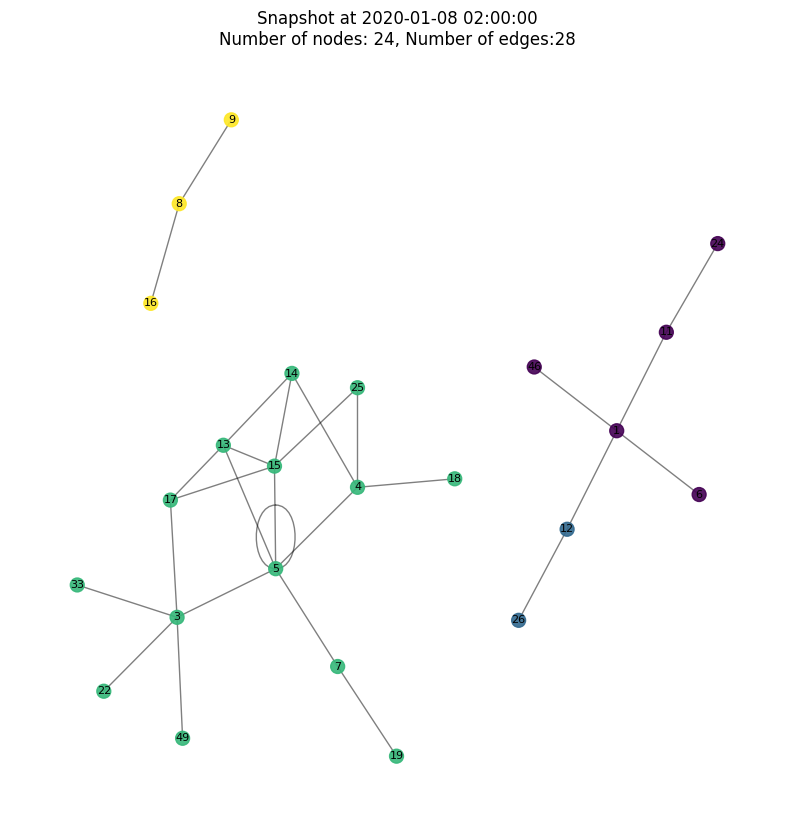

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from networkx.drawing.nx_agraph import graphviz_layout

# Load the dataset
df = pd.read_csv('X-IIoTID.csv', low_memory=False)

# Convert 'Timestamp' to datetime and round down to the nearest hour
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.floor('H')

# Ensure 'total_bytes' is numeric and handle non-numeric values
df['total_bytes'] = pd.to_numeric(df['total_bytes'], errors='coerce')
df.dropna(subset=['total_bytes'], inplace=True)  # Drop rows where 'total_bytes' couldn't be converted

# Initialize the snapshots dictionary and a dictionary for node IDs
snapshots = {}
node_ids = {}
current_id = 1  # Start with an ID of 1

# Group the DataFrame by the hourly timestamp
for hourly_timestamp, group in df.groupby('timestamp'):
    G = nx.Graph()  # Create a new graph for each hour

    for index, row in group.iterrows():
        # Check if the IP already has an ID assigned, if not, assign a new one
        for ip in [row['Scr_IP'], row['Des_IP']]:
            if ip not in node_ids:
                node_ids[ip] = current_id
                current_id += 1

        src_id = node_ids[row['Scr_IP']]
        dest_id = node_ids[row['Des_IP']]
        
        # Assuming 'class3' column exists and dictates the label
        node_label_src = 'Normal' if row['class3'] == 'NormalActivity' else 'Attack'
        node_label_dest = 'Normal'  # Assume destinations are 'Normal', adjust as needed

        # Add nodes with labels and edges with weights to the graph
        G.add_node(src_id, label=node_label_src)
        G.add_node(dest_id, label=node_label_dest)
        G.add_edge(src_id, dest_id, weight=float(row['total_bytes']))  # Ensure weight is a float

    snapshots[hourly_timestamp] = G

# Detect communities for each snapshot using the Louvain method
for timestamp, graph in snapshots.items():
    # Skip graphs with no edges or invalid weights
    if graph.number_of_edges() == 0 or not all(data.get('weight') for u, v, data in graph.edges(data=True)):
        continue
    
    partition = community_louvain.best_partition(graph, weight='weight')
    for node, comm_id in partition.items():
        graph.nodes[node]['community'] = comm_id

# Visualization loop for each snapshot, now in chronological order
sorted_timestamps = sorted(snapshots.keys())
max_snapshots_to_visualize = 20  # Adjust as needed

for i, timestamp in enumerate(sorted_timestamps):
    if i >= max_snapshots_to_visualize:
        break  # Limit the number of visualized snapshots

    graph = snapshots[timestamp]
    
    # Only visualize if the graph is not empty
    if len(graph.nodes()) == 0:
        continue
    
    plt.figure(figsize=(10, 10))  # Further increase figure size
    plt.title(f'Snapshot at {timestamp}\nNumber of nodes: {graph.number_of_nodes()}, Number of edges:{graph.number_of_edges()}')
    
    # Use the Graphviz layout for better control
    pos = graphviz_layout(graph, prog='neato')

    # Scale the positions to prevent overlap
    pos = {node: (x * 2, y * 2) for node, (x, y) in pos.items()}

    # Prepare color map for nodes based on their community
    community_colors = [graph.nodes[node].get('community', 0) for node in graph.nodes()]
    
    # Draw the graph with nodes colored by community
    nx.draw_networkx_nodes(graph, pos, node_size=100, node_color=community_colors, alpha=0.9)  # Decrease node size
    nx.draw_networkx_edges(graph, pos, width=1, alpha=0.5)  # Adjust edge width
    nx.draw_networkx_labels(graph, pos, font_size=8)  # Adjust font size

    plt.axis('off')
    plt.show()